# Import

In [ ]:
!pip install ultralytics

import cv2
import os
import glob
import random
import matplotlib.pyplot as plt

from ultralytics import RTDETR
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

# Visualizing Sample Dataset

Class: pothole (501 images found, showing 5)


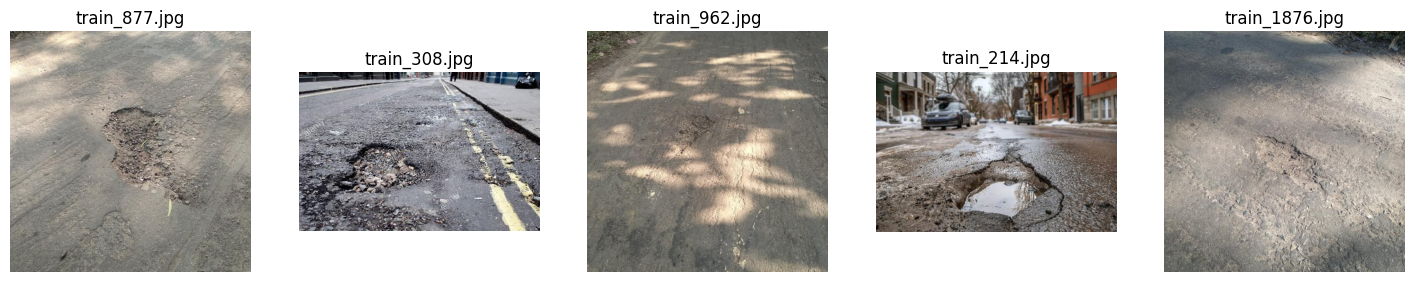

Saved as pothole_sample_dataset.pdf
Class: speedbump (1587 images found, showing 5)


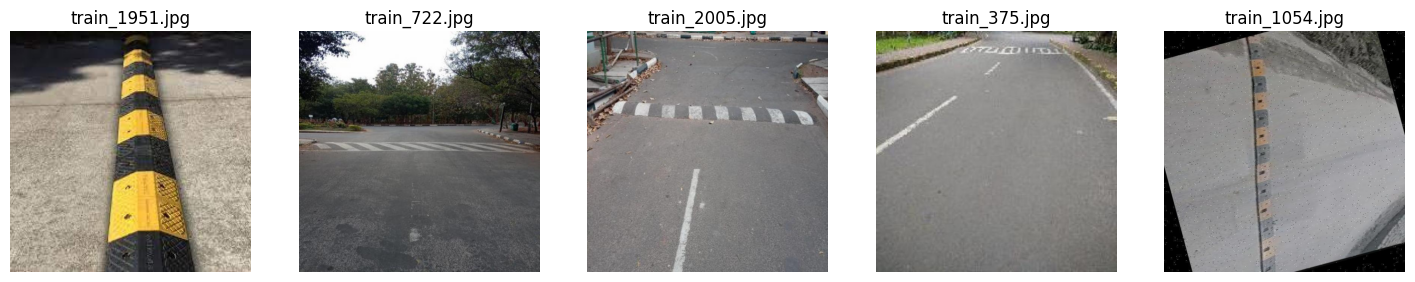

Saved as speedbump_sample_dataset.pdf


In [ ]:

# Set Directory
IMG_DIR = '/kaggle/input/pothole-speedbumps/merged_dataset/train/images'
LBL_DIR = '/kaggle/input/pothole-speedbumps/merged_dataset/train/labels'

class_names = ['pothole', 'speedbump']
num_samples = 5

# img_files = set(os.path.splitext(os.path.basename(x))[0] for x in glob.glob(os.path.join(IMG_DIR, '*.jpg')))
# lbl_files = set(os.path.splitext(os.path.basename(x))[0] for x in glob.glob(os.path.join(LBL_DIR, '*.txt')))

# # Check image without label
# img_no_label = img_files - lbl_files
# print(f"Images without label files: {len(img_no_label)}")

# # Check label without image file
# empty_label_files = []
# for fname in lbl_files:
#     lbl_path = os.path.join(LBL_DIR, fname + '.txt')
#     with open(lbl_path, 'r') as f:
#         if len(f.read().strip()) == 0:
#             empty_label_files.append(fname)
# print(f"Label files with no objects: {len(empty_label_files)}")

# Find images belonging to each class
class_to_images = {i: [] for i in range(len(class_names))}

for lbl_file in glob.glob(os.path.join(LBL_DIR, '*.txt')):
    with open(lbl_file, 'r') as f:
        lines = f.readlines()
        class_ids = [int(line.strip().split()[0]) for line in lines]
        for c in set(class_ids):  # Avoid duplicates if multiple of same class
            fname = os.path.splitext(os.path.basename(lbl_file))[0] + '.jpg'
            img_path = os.path.join(IMG_DIR, fname)
            class_to_images[c].append(img_path)

# Plot raw images, 5 per class
for c, images in class_to_images.items():
    sample_imgs = random.sample(images, min(num_samples, len(images)))
    print(f"Class: {class_names[c]} ({len(images)} images found, showing {len(sample_imgs)})")
    plt.figure(figsize=(18, 4))
    for i, img_path in enumerate(sample_imgs):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    pdf_path = os.path.join(f'{class_names[c]}_sample_dataset.pdf')
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved as {pdf_path}")

# Set up and Train the model (RT-DETR)

In [ ]:
# Load the RT-DETR model (large)
model = RTDETR('rtdetr-l.pt')

# Print model architecture summary
print('Model Architecture: ')
print('-' * 40)
print(model.model)
print('-' * 40)

# Train the model
# model.train(data='/kaggle/input/pothole-speedbumps/merged_dataset/data.yaml', epochs=50, imgsz=640)

# Train the model with safer settings to prevent NaN issues
model.train(
    data='/kaggle/input/pothole-speedbumps/merged_dataset/data.yaml',
    epochs=50,
    imgsz=640,
    lr0=0.0005,  # Lower learning rate to prevent loss explosion
    patience=10  # Early stopping if no improvement for 10 epochs
)

100%|██████████| 63.4M/63.4M [00:00<00:00, 130MB/s] 


Model Architecture: 
----------------------------------------
DetectionModel(
  (model): Sequential(
    (0): HGStem(
      (stem1): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2a): Conv(
        (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2b): Conv(
        (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, m

100%|██████████| 755k/755k [00:00<00:00, 30.1MB/s]


Overriding model.yaml nc=80 with nc=2
WARNING ⚠️ no model scale passed. Assuming scale='l'.

                   from  n    params  module                                       arguments                     
  0                  -1  1     25248  ultralytics.nn.modules.block.HGStem          [3, 32, 48]                   
  1                  -1  6    155072  ultralytics.nn.modules.block.HGBlock         [48, 48, 128, 3, 6]           
  2                  -1  1      1408  ultralytics.nn.modules.conv.DWConv           [128, 128, 3, 2, 1, False]    
  3                  -1  6    839296  ultralytics.nn.modules.block.HGBlock         [128, 96, 512, 3, 6]          
  4                  -1  1      5632  ultralytics.nn.modules.conv.DWConv           [512, 512, 3, 2, 1, False]    
  5                  -1  6   1695360  ultralytics.nn.modules.block.HGBlock         [512, 192, 1024, 5, 6, True, False]
  6                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 7.6±4.8 MB/s, size: 60.0 KB)


train: Scanning /kaggle/input/pothole-speedbumps/merged_dataset/train/labels... 2090 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2090/2090 [00:06<00:00, 345.12it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/pothole-speedbumps/merged_dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.6±3.6 MB/s, size: 40.1 KB)


val: Scanning /kaggle/input/pothole-speedbumps/merged_dataset/valid/labels... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:03<00:00, 187.40it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/pothole-speedbumps/merged_dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50      13.3G      1.206      1.056      1.362         20        640: 100%|██████████| 131/131 [02:53<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.44it/s]

                   all        597        856      0.543      0.389      0.395      0.229



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       2/50      14.2G     0.5877     0.6278     0.3941         28        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        597        856      0.709       0.61      0.652      0.387



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       3/50      14.1G     0.5633     0.6505     0.3706         17        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.691      0.562      0.626      0.353



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       4/50      14.2G     0.5449     0.6536     0.3484         27        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.75      0.608      0.668      0.404



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       5/50        14G     0.5141     0.6282     0.3353         23        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        597        856      0.781      0.679      0.725       0.44



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       6/50      14.2G     0.5161     0.6004      0.334         32        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.733       0.68        0.7       0.42



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       7/50      14.3G     0.4933     0.6199     0.3136         26        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856      0.726      0.707       0.73      0.453



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       8/50      13.5G     0.4829     0.5929     0.3097         12        640: 100%|██████████| 131/131 [02:50<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.763      0.609      0.683       0.41



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       9/50      14.1G     0.4823     0.5624     0.3132         23        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.78      0.706      0.745      0.466



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/50      14.2G     0.4664     0.5583     0.3029         20        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856      0.841      0.761      0.803       0.52



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      11/50      14.3G     0.4458     0.5602     0.2747         34        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.811      0.725      0.776      0.497



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      12/50      14.2G     0.4651     0.5392     0.3039         34        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.851      0.733      0.798      0.508



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      13/50      13.9G     0.4437     0.5565     0.2782         22        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.845      0.754       0.82      0.539



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      14/50      13.5G     0.4582     0.5345     0.2862         17        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.86      0.741      0.813      0.538



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      15/50      14.2G     0.4279     0.5369     0.2705         31        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.805       0.76      0.809      0.523



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      16/50      13.5G     0.4298     0.5311     0.2719         20        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.846      0.739      0.795      0.525



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      17/50      14.1G     0.4243     0.5381     0.2742         22        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856      0.816      0.754      0.784       0.52



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      18/50      13.4G     0.4248     0.5404      0.261         23        640: 100%|██████████| 131/131 [02:50<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.806      0.752      0.792      0.534



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      19/50      14.3G     0.4061     0.5033     0.2528         32        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856       0.85      0.771      0.821      0.556



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      20/50      14.2G     0.4095     0.4946     0.2578         29        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856      0.858      0.758      0.834       0.56



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      21/50        14G     0.3983     0.4898     0.2435         30        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.887      0.774      0.845      0.573



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      22/50      13.4G     0.3935      0.484     0.2412         24        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        597        856      0.866      0.777      0.835      0.579



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      23/50      13.5G     0.3847     0.4863     0.2373         25        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.88      0.776      0.846      0.586



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      24/50      14.2G     0.3776     0.4562     0.2315         31        640: 100%|██████████| 131/131 [02:50<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.88      0.738      0.828      0.577



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      25/50      14.2G     0.3737     0.4776     0.2291         35        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.86      0.796      0.844      0.585



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      26/50      14.3G     0.3847     0.4618       0.23         33        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.85       0.79      0.824      0.556



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      27/50      14.2G     0.3677     0.4585     0.2279         25        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.875      0.804       0.85      0.593



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      28/50      14.2G     0.3651     0.4503     0.2241         38        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.88      0.801       0.86      0.593



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      29/50      13.3G     0.3602     0.4634      0.221         20        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        597        856      0.894      0.811      0.861      0.595



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      30/50      14.2G     0.3525      0.439     0.2114         31        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        597        856      0.888      0.811      0.863      0.599



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      31/50      14.2G     0.3456      0.434     0.2116         31        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.893      0.802      0.859      0.596



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      32/50      14.2G     0.3482     0.4401     0.2071         22        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.864      0.818      0.862      0.604



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      33/50      14.1G      0.347     0.4331     0.2037         40        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.862      0.808      0.857      0.592



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      34/50      14.2G     0.3429      0.427     0.2064         25        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.846      0.842      0.868       0.61



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      35/50      14.2G     0.3418     0.4365     0.2033         29        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.863      0.836      0.864      0.612



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      36/50      14.2G      0.325     0.4118     0.1944         22        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.925      0.809      0.873      0.614



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      37/50      14.2G     0.3274     0.4114     0.1897         42        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.897      0.817      0.868      0.619



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      38/50      14.2G     0.3199     0.4133     0.1913         27        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.906      0.819      0.869       0.61



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      39/50      14.3G     0.3122     0.4008     0.1883         30        640: 100%|██████████| 131/131 [02:50<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.899      0.817      0.876      0.622



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      40/50      14.3G     0.3119     0.3973     0.1862         24        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]


                   all        597        856      0.892      0.837      0.876      0.631
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      41/50      14.1G     0.2595     0.3485     0.1769         17        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.896       0.82      0.877       0.63



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      42/50      13.5G     0.2487     0.3325      0.162         16        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        597        856      0.889      0.831       0.88      0.633



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      43/50      14.2G      0.241      0.321     0.1562         20        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.874      0.835      0.878       0.64



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      44/50      14.2G     0.2409       0.32     0.1556         10        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.866      0.851      0.882      0.639



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      45/50      14.2G     0.2288     0.3092     0.1428         15        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856       0.89      0.849      0.886      0.644



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      46/50      14.3G     0.2281     0.3039      0.144         14        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.897      0.846      0.892      0.649



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      47/50      13.5G     0.2186     0.3001     0.1391         18        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.892      0.851      0.894      0.648



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      48/50      14.2G     0.2239     0.2981     0.1396         13        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.899      0.846       0.89       0.65



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      49/50      14.2G     0.2185     0.2935     0.1329         14        640: 100%|██████████| 131/131 [02:50<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.908       0.85       0.89      0.651



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      50/50      13.5G     0.2097     0.2856     0.1273         15        640: 100%|██████████| 131/131 [02:51<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        597        856      0.908      0.841      0.889      0.651



50 epochs completed in 2.579 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 66.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 66.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.50it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        597        856      0.909       0.85       0.89      0.651
               pothole        140        344      0.849      0.738      0.804       0.54
             speedbump        457        512      0.969      0.961      0.975      0.762
Speed: 0.1ms preprocess, 17.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d0f445f8b90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# Test with Pothole Image


image 1/1 /kaggle/input/pothole-speedbumps/merged_dataset/test/images/test_10.jpg: 640x640 4 potholes, 31.4ms
Speed: 3.9ms preprocess, 31.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train2


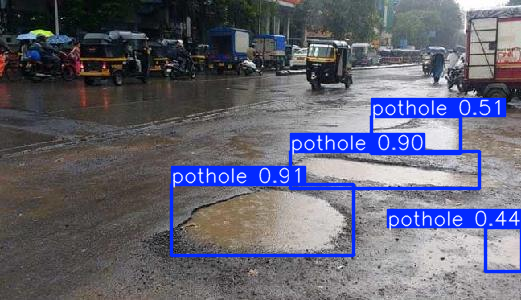

In [ ]:
# Run prediction on an image
results = model.predict(source='/kaggle/input/pothole-speedbumps/merged_dataset/test/images/test_10.jpg', save=True)

# Display results
results[0].show()


# Test with Speedbump Image


image 1/1 /kaggle/input/pothole-speedbumps/merged_dataset/test/images/test_0.jpg: 640x640 1 speedbump, 31.9ms
Speed: 1.6ms preprocess, 31.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train3


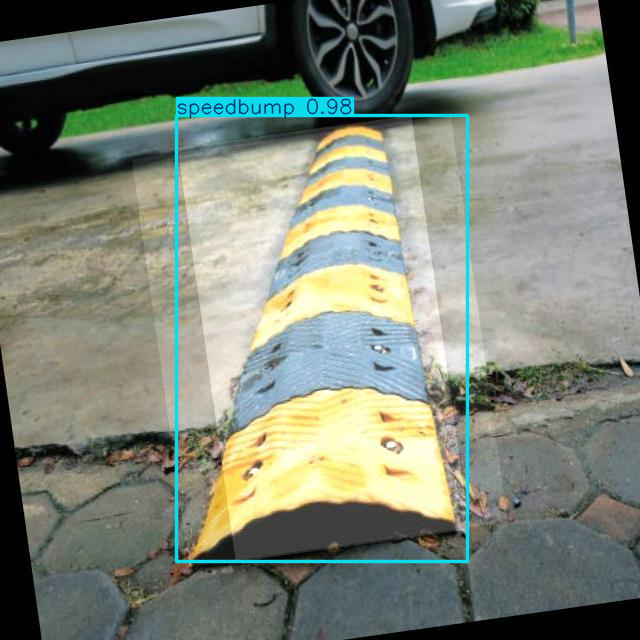

In [ ]:
# Run prediction on an image
results = model.predict(source='/kaggle/input/pothole-speedbumps/merged_dataset/test/images/test_0.jpg', save=True)

# Display results
results[0].show()


# Pothole Video Detection Test with RT-DETR Model

In [ ]:
# Load trained RT-DETR model
model = RTDETR('/kaggle/working/runs/detect/train/weights/best.pt')

# Open the video file for reading
cap = cv2.VideoCapture('/kaggle/input/potholes-detection-inference-on-videos/pothole.mp4')

fps = cap.get(cv2.CAP_PROP_FPS) # Get video frame rate (FPS)
frame_count = 0
max_frames = 300  # Limit to 300 frames for speed / quota
output_size = (640, 360) # Set output frame size

# Video writer to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_pothole_detection_rtdetr.mp4', fourcc, fps, output_size)

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to match training image size
    frame = cv2.resize(frame, output_size)

    # Run inference
    results = model(frame)

    # Get annotated frame with bounding boxes and labels
    annotated_frame = results[0].plot()

    # Write annotated frame to output video
    out.write(annotated_frame)

    frame_count += 1

# Release resources
cap.release()
out.release()



0: 640x640 13 potholes, 44.4ms
Speed: 2.3ms preprocess, 44.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 potholes, 45.7ms
Speed: 2.3ms preprocess, 45.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 potholes, 44.1ms
Speed: 2.3ms preprocess, 44.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 potholes, 44.6ms
Speed: 2.4ms preprocess, 44.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 potholes, 44.2ms
Speed: 2.9ms preprocess, 44.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 potholes, 44.0ms
Speed: 2.8ms preprocess, 44.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 potholes, 45.1ms
Speed: 2.3ms preprocess, 45.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 potholes, 44.1ms
Speed: 2.4ms preprocess, 44.1ms inference, 0.6ms postprocess per 

In [ ]:
import shutil


shutil.make_archive('runs', 'zip', 'runs')

'/kaggle/working/runs.zip'